# Base Gridsearch: Reproduce Plots/Tables


This notebook reproduces the **Base (static) Grid Search** plots/tables used in the paper.

**Expected repo layout (relative paths):**
- `Structured Outputs/Base Gridsearch/BaseTrain_parsed.csv` (or `.xlsx`)
- This notebook should live in `Plotting Code/`

Outputs (figures + derived tables) are saved into:
- `Structured Outputs/Base Gridsearch/Images/`


In [1]:
# --- Imports ---
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
SAVE_FIGS = True              # Set False if you only want to display plots
FIG_DPI = 200
SEEDS_IN_ORDER = [38042, 217401, 637451, 207796, 45921]  # order the log cycles through seeds

def find_project_root(start: Path | None = None) -> Path:
    """Walk upward until we find 'Structured Outputs'."""
    here = (start or Path.cwd()).resolve()
    for _ in range(10):
        if (here / 'Structured Outputs').exists():
            return here
        here = here.parent
    raise FileNotFoundError(
        "Could not find project root containing 'Structured Outputs'.\n"
        "Run this notebook from within the repo (ideally from 'Plotting Code/')."
    )

PROJECT_ROOT = find_project_root()
STRUCTURED_DIR = PROJECT_ROOT / 'Structured Outputs'
DATA_DIR = STRUCTURED_DIR / 'Base Gridsearch'
OUT_DIR = DATA_DIR / 'Images'
OUT_DIR.mkdir(parents=True, exist_ok=True)

CSV_PATH = DATA_DIR / 'BaseTrain_parsed.csv'
XLSX_PATH = DATA_DIR / 'BaseTrain_parsed.xlsx'

def save_fig(fig: plt.Figure, stem: str):
    """Save both PNG + PDF for easy paper inclusion."""
    if not SAVE_FIGS:
        return
    png = OUT_DIR / f"{stem}.png"
    pdf = OUT_DIR / f"{stem}.pdf"
    fig.savefig(png, dpi=FIG_DPI, bbox_inches='tight')
    fig.savefig(pdf, bbox_inches='tight')
    print(f"Saved: {png}\nSaved: {pdf}")

In [2]:
# --- Load data ---
if CSV_PATH.exists():
    df = pd.read_csv(CSV_PATH)
elif XLSX_PATH.exists():
    # fall back to the 'parsed_epochs' sheet if needed
    df = pd.read_excel(XLSX_PATH, sheet_name=0)
else:
    raise FileNotFoundError(f"Missing both {CSV_PATH} and {XLSX_PATH}")

df.head(), df.shape

(      seed  phase  phase_name  phase_total_runs  phase_epochs_per_run  \
 0  [38042]    NaN         NaN               NaN                   NaN   
 1  [38042]    NaN         NaN               NaN                   NaN   
 2  [38042]    NaN         NaN               NaN                   NaN   
 3  [38042]    NaN         NaN               NaN                   NaN   
 4  [38042]    NaN         NaN               NaN                   NaN   
 
    run_idx  run_total  lr  wd  bs  drop_path_rate  epoch  epoch_total    loss  \
 0      NaN        NaN NaN NaN NaN             NaN      1           70  2.2998   
 1      NaN        NaN NaN NaN NaN             NaN      1           70  2.2608   
 2      NaN        NaN NaN NaN NaN             NaN      1           70  2.3122   
 3      NaN        NaN NaN NaN NaN             NaN      1           70  2.2560   
 4      NaN        NaN NaN NaN NaN             NaN      1           70  2.3255   
 
    train_acc_pct  test_acc_pct dl_time train_time eval_time

In [3]:
# --- Ensure we have a 'seed' column ---
# Many logs store results as: (run_idx, epoch) repeated once per seed, in a fixed order.
# If the 'seed' column is missing, we reconstruct it by assigning SEEDS_IN_ORDER to each
# (run_idx, epoch) group in that order.

if 'seed' not in df.columns:
    # Sort to ensure deterministic assignment
    df = df.sort_values(['run_idx', 'epoch'], kind='mergesort').reset_index(drop=True)  # stable sort preserves within-group seed order

    def assign_seeds(group: pd.DataFrame) -> pd.DataFrame:
        group = group.copy()
        if len(group) != len(SEEDS_IN_ORDER):
            # If the parser produced a different multiplicity, we fail loudly to avoid silent bugs.
            raise ValueError(
                f"Expected {len(SEEDS_IN_ORDER)} rows for each (run_idx, epoch), got {len(group)}.\n"
                "If your log format differs, update SEEDS_IN_ORDER logic accordingly."
            )
        group['seed'] = SEEDS_IN_ORDER
        return group

    df = df.groupby(['run_idx', 'epoch'], group_keys=False).apply(assign_seeds)
    df = df.reset_index(drop=True)

# --- Fix occasional missing hyperparameter configs (rare parser artifact) ---
# If one seed's first row for a run is missing hyperparams, we backfill from another seed
# within the same run (configs are identical across seeds by construction).
HP_COLS = ['lr', 'wd', 'bs', 'drop_path_rate']
for run_idx, g in df.groupby('run_idx'):
    # Find a non-null reference config row
    ref = g[HP_COLS].dropna().head(1)
    if len(ref) == 0:
        continue
    ref_vals = ref.iloc[0].to_dict()
    # Fill missing hp values for that run
    mask = (df['run_idx'] == run_idx)
    for c in HP_COLS:
        df.loc[mask, c] = df.loc[mask, c].fillna(ref_vals[c])

df[['run_idx','epoch','seed'] + HP_COLS].head(12)

,run_idx,epoch,seed,lr,wd,bs,drop_path_rate
0,NaN,1,[38042],NaN,NaN,NaN,NaN
1,NaN,1,[38042],NaN,NaN,NaN,NaN
2,NaN,1,[38042],NaN,NaN,NaN,NaN
3,NaN,1,[38042],NaN,NaN,NaN,NaN
4,NaN,1,[38042],NaN,NaN,NaN,NaN
5,NaN,1,[38042],NaN,NaN,NaN,NaN
6,NaN,1,[38042],NaN,NaN,NaN,NaN
7,NaN,1,[38042],NaN,NaN,NaN,NaN
8,NaN,1,[38042],NaN,NaN,NaN,NaN
9,NaN,1,[38042],NaN,NaN,NaN,NaN


In [4]:
# --- Helper: per-(run_idx, seed) final metrics (at last epoch) ---
EPOCH_MAX = int(df['epoch'].max())
df_final = (
    df[df['epoch'] == EPOCH_MAX]
    .copy()
    .rename(columns={'test_acc_pct': 'final_val_acc_pct', 'loss': 'final_train_loss'})
)

# Some files call validation accuracy 'test_acc_pct' (CIFAR-10 test split used as val).
keep_cols = ['run_idx', 'seed'] + HP_COLS + ['final_train_loss', 'final_val_acc_pct']
df_final = df_final[keep_cols].reset_index(drop=True)

df_final.head()

,run_idx,seed,lr,wd,bs,drop_path_rate,final_train_loss,final_val_acc_pct
0,NaN,[38042],NaN,NaN,NaN,NaN,0.2090,79.39
1,NaN,[38042],NaN,NaN,NaN,NaN,0.3557,79.59
2,NaN,[38042],NaN,NaN,NaN,NaN,0.4119,79.89
3,NaN,[38042],NaN,NaN,NaN,NaN,0.2399,79.74
4,NaN,[38042],NaN,NaN,NaN,NaN,0.3658,79.80


Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/Base Gridsearch/Images/fig1_base_gridsearch_distributions.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/Base Gridsearch/Images/fig1_base_gridsearch_distributions.pdf


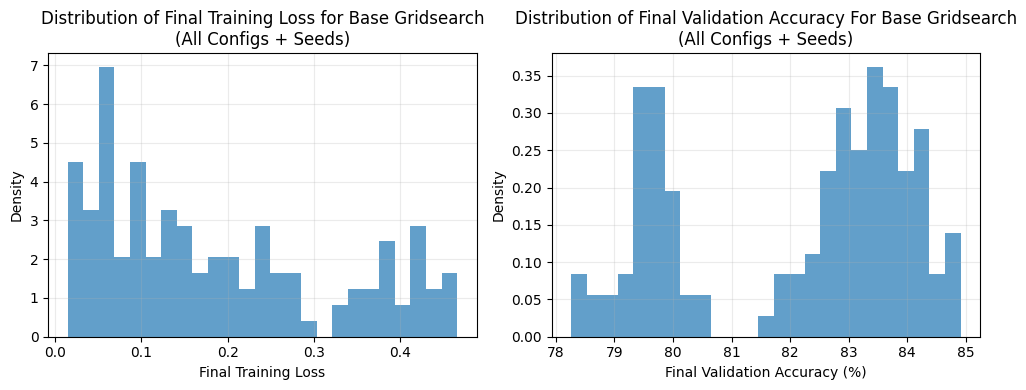

In [5]:
# === Figure 1: Distributions of final training loss and final validation accuracy ===
final_losses = df_final['final_train_loss'].astype(float).values
final_accs = df_final['final_val_acc_pct'].astype(float).values

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(final_losses, bins=25, density=True, alpha=0.7)
axes[0].set_title('Distribution of Final Training Loss for Base Gridsearch\n(All Configs + Seeds)')
axes[0].set_xlabel('Final Training Loss')
axes[0].set_ylabel('Density')
axes[0].grid(True, alpha=0.25)

axes[1].hist(final_accs, bins=25, density=True, alpha=0.7)
axes[1].set_title('Distribution of Final Validation Accuracy For Base Gridsearch\n(All Configs + Seeds)')
axes[1].set_xlabel('Final Validation Accuracy (%)')
axes[1].set_ylabel('Density')
axes[1].grid(True, alpha=0.25)

plt.tight_layout()
save_fig(fig, 'fig1_base_gridsearch_distributions')
plt.show()

In [6]:
# === Figure 2: Mean ± 1 std across seeds for the best static-grid configuration ===
# We select the configuration (run_idx) with the highest mean final validation accuracy across seeds.
best_run_idx = (
    df_final.groupby('run_idx')['final_val_acc_pct']
    .mean()
    .sort_values(ascending=False)
    .index[0]
)
print(f"Best run_idx by mean final val acc across seeds: {best_run_idx}")

df_best = df[df['run_idx'] == best_run_idx].copy()

# Aggregate across seeds at each epoch
agg = (
    df_best.groupby('epoch', as_index=False)
    .agg(
        loss_mean=('loss', 'mean'),
        loss_std=('loss', 'std'),
        train_acc_mean=('train_acc_pct', 'mean'),
        train_acc_std=('train_acc_pct', 'std'),
        val_acc_mean=('test_acc_pct', 'mean'),
        val_acc_std=('test_acc_pct', 'std'),
    )
)
agg = agg.sort_values('epoch')

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: training loss
axes[0].plot(agg['epoch'], agg['loss_mean'], label='Mean Loss')
axes[0].fill_between(
    agg['epoch'],
    agg['loss_mean'] - agg['loss_std'].fillna(0),
    agg['loss_mean'] + agg['loss_std'].fillna(0),
    alpha=0.2,
    label='±1 Std Dev'
)
axes[0].set_title(f'Training Loss Variability\n(Config {best_run_idx})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.25)
axes[0].legend()

# Right: train/val accuracy
axes[1].plot(agg['epoch'], agg['train_acc_mean'], label='Train Mean')
axes[1].fill_between(
    agg['epoch'],
    agg['train_acc_mean'] - agg['train_acc_std'].fillna(0),
    agg['train_acc_mean'] + agg['train_acc_std'].fillna(0),
    alpha=0.2,
    label='±1 Std Dev (Train)'
)
axes[1].plot(agg['epoch'], agg['val_acc_mean'], label='Val Mean')
axes[1].fill_between(
    agg['epoch'],
    agg['val_acc_mean'] - agg['val_acc_std'].fillna(0),
    agg['val_acc_mean'] + agg['val_acc_std'].fillna(0),
    alpha=0.2,
    label='±1 Std Dev (Val)'
)
axes[1].set_title(f'Accuracy Variability\n(Config {best_run_idx})')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].grid(True, alpha=0.25)
axes[1].legend()

plt.tight_layout()
save_fig(fig, 'fig2_base_gridsearch_best_config_variability')
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# === Table 2: Top run per seed (by FINAL validation accuracy) + hyperparameters ===
# This matches the paper's table format: one row per seed.

table2 = (
    df_final.sort_values(['seed', 'final_val_acc_pct'], ascending=[True, False])
    .groupby('seed', as_index=False)
    .head(1)
    .sort_values('seed')
    .rename(columns={
        'final_val_acc_pct': 'Accuracy (%)',
        'lr': 'Learning Rate',
        'wd': 'Weight Decay',
        'bs': 'Batch Size',
        'drop_path_rate': 'Drop Path Rate'
    })
)

table2_out = OUT_DIR / 'table2_top_run_per_seed.csv'
table2.to_csv(table2_out, index=False)
print(f"Saved: {table2_out}")

table2